# Comparison of Chlorophyll and Nitrate at CE07 and GI01
By Sage Lichtenwalner 5/21/2019, revised 10/2/2019

The following script generates a quick plot of Chlorophyll and Nitrate data at 2 locations: one coastal, one global.  The original version of this notebook retrieved data from 4/2015 to 9/2017 to be used as an [extension activity](http://explorations.visualocean.net/productivity/silke1.php) for one of the Productive Data Explorations, originally created in 2016.  Unfortuatntely, the early Nitrate data in the OOI was not very good.  Better nitrate sensors were deployed throughout the OOI during the summer of 2018.

In [1]:
# Notebook Setup
import requests
import os
import re
import xarray as xr
import numpy as np
import pandas as pd
! pip install netcdf4==1.5.0

# Setup default plot styles
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

## Request Data

In [0]:
API_USERNAME = ''
API_TOKEN = ''

In [0]:
def request_data(reference_designator,method,stream,start_date=None,end_date=None):
  site = reference_designator[:8]
  node = reference_designator[9:14]
  instrument = reference_designator[15:]
  
  # Create the request URL
  api_base_url = 'https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv'
  data_request_url ='/'.join((api_base_url,site,node,instrument,method,stream))

  # All of the following are optional, but you should specify a date range
  params = {
    'format':'application/netcdf',
    'include_provenance':'true',
    'include_annotations':'true'
  }
  if (start_date):
    params['beginDT'] = start_date
  if (end_date):
    params['endDT'] = end_date

  # Make the data request
  r = requests.get(data_request_url, params=params, auth=(API_USERNAME, API_TOKEN))
  data = r.json()
  
  # Return just the THREDDS URL upon success, else return error message
  if 'allURLs' in data.keys():
    return data['allURLs'][0]
  else:
    print('Request Error')
    print(data['message']['status'])
    return data


In [0]:
# Data Requests
sd = '2018-01-01T00:00:00.000Z'
ed = '2019-10-01T00:00:00.000Z'
# request_data('CE07SHSM-RID27-02-FLORTD000','telemetered','flort_sample',sd,ed)
# request_data('CE07SHSM-RID26-07-NUTNRB000','telemetered','suna_dcl_recovered',sd,ed)
# request_data('GI01SUMO-RID16-02-FLORTD000','telemetered','flort_sample',sd,ed)
# request_data('GI01SUMO-RID16-07-NUTNRB000','telemetered','suna_dcl_recovered',sd,ed)

## Load Datasets

In [0]:
url_flo_ce = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20191002T204441398Z-CE07SHSM-RID27-02-FLORTD000-telemetered-flort_sample/catalog.html'
url_nut_ce = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20191002T204656427Z-CE07SHSM-RID26-07-NUTNRB000-telemetered-suna_dcl_recovered/catalog.html'
url_flo_gi = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20191002T204505449Z-GI01SUMO-RID16-02-FLORTD000-telemetered-flort_sample/catalog.html'
url_nut_gi = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20191002T204518534Z-GI01SUMO-RID16-07-NUTNRB000-telemetered-suna_dcl_recovered/catalog.html'

In [0]:
def get_data(url,bad_inst=''):
  '''Function to grab all data from specified directory'''
  tds_url = 'https://opendap.oceanobservatories.org/thredds/dodsC'
  datasets = requests.get(url).text
  urls = re.findall(r'href=[\'"]?([^\'" >]+)', datasets)
  x = re.findall(r'(ooi/.*?.nc)', datasets)
  for i in x:
    if i.endswith('.nc') == False:
      x.remove(i)
  for i in x:
    try:
      float(i[-4])
    except:
      x.remove(i)
  datasets = [os.path.join(tds_url, i) for i in x]
  
  # Remove extraneous files if necessary
  selected_datasets = []
  for d in datasets:
    if (bad_inst) and bad_inst in d:
      pass
    elif 'ENG000' in d: #Remove engineering streams for gliders
      pass
    elif '_cal_' in d: #Remove pco2 cal streams
      pass
    else:
      selected_datasets.append(d)
  selected_datasets.reverse() # Flip order so older datasets are first
  # print(selected_datasets)
  
  # Load in dataset
  ds = xr.open_mfdataset(selected_datasets) #,data_vars=['seawater_temperature','practical_salinity','corrected_dissolved_oxygen'])
  ds = ds.swap_dims({'obs': 'time'}) # Swap the primary dimension
  # ds = ds.chunk({'time': 3600}) # Used for optimization
  # ds = ds.sortby('time') # Data from different deployments can overlap so we want to sort all data by time stamp.
  return ds
  

In [7]:
%%time
data_flo_ce = get_data(url_flo_ce,'ctdbp')
data_nut_ce = get_data(url_nut_ce,'ctdbp')
data_flo_gi = get_data(url_flo_gi,'ctdbp')
data_nut_gi = get_data(url_nut_gi,'ctdbp')

CPU times: user 4.57 s, sys: 1.38 s, total: 5.95 s
Wall time: 2min 3s


In [0]:
import numpy as np
def reject_outliers(data, m=5):
    """
    Reject outliers beyond m standard deviations of the mean.
    :param data: numpy array containing data
    :param m: number of standard deviations from the mean. Default: 3
    """
    stdev = np.nanstd(data)
    if stdev > 0.0:
        ind = abs(data - np.nanmean(data)) < m * stdev
    else:
        ind = len(data) * [True]

    return ind


In [0]:
# Filter datasets
data_nut_ce['nitrate_concentration'] = data_nut_ce['nitrate_concentration'].where(data_nut_ce['nitrate_concentration']>0)
data_nut_ce['nitrate_concentration'] = data_nut_ce['nitrate_concentration'].where(reject_outliers(data_nut_ce['nitrate_concentration']))
data_nut_gi['nitrate_concentration'] = data_nut_gi['nitrate_concentration'].where(data_nut_gi['nitrate_concentration']>0)


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in less
  return func(*args2)


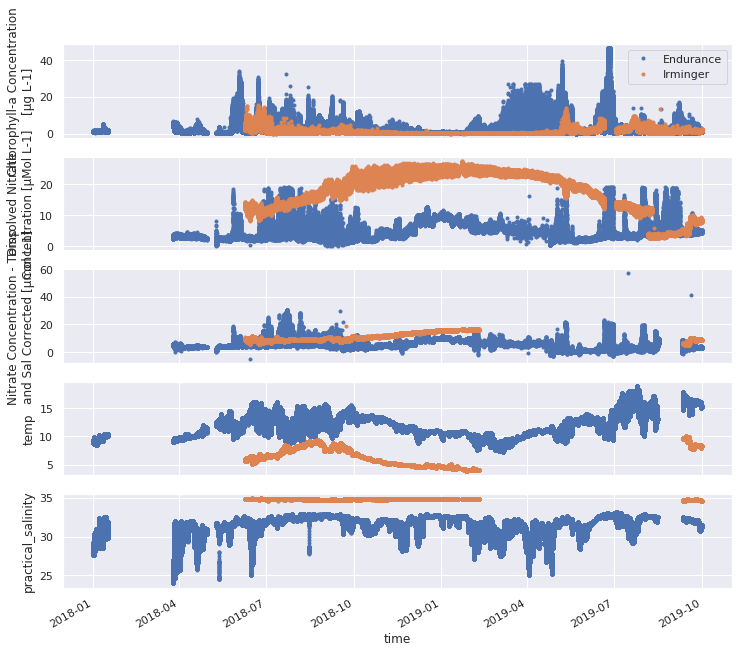

In [10]:
# Plot the data
fig, (ax1,ax2,ax3,ax4,ax5) = plt.subplots(5,1, sharex=True, figsize=(12,10))

data_flo_ce.fluorometric_chlorophyll_a.plot(ax=ax1, label="Endurance", marker='.', linestyle='')
data_flo_gi.fluorometric_chlorophyll_a.plot(ax=ax1, label="Irminger", marker='.', linestyle='')

data_nut_ce.nitrate_concentration.plot(ax=ax2, label="Endurance", marker='.', linestyle='')
data_nut_gi.nitrate_concentration.plot(ax=ax2, label="Irminger", marker='.', linestyle='')

data_nut_ce.salinity_corrected_nitrate.plot(ax=ax3, label="Endurance", marker='.', linestyle='')
data_nut_gi.salinity_corrected_nitrate.plot(ax=ax3, label="Irminger",marker='.', linestyle='')

data_flo_ce.temp.plot(ax=ax4,marker='.',linestyle='', label="Endurance")
data_flo_gi.temp.plot(ax=ax4,marker='.',linestyle='', label="Irmginer")

data_flo_ce.practical_salinity.plot(ax=ax5,marker='.',linestyle='', label="Endurance")
data_flo_gi.practical_salinity.plot(ax=ax5,marker='.',linestyle='', label="Irmginer")

ax1.set_xlabel('')
ax2.set_xlabel('')
ax3.set_xlabel('')
ax4.set_xlabel('')

ax1.legend()

plt.savefig("silke_chl_nitrate1.png");

So, unfortunately, the Irminger CTD cuts out mid-way through the deployment, which means the Temp-Sal Corrected Nitrate isn't available either.  I tried to use the function to calculate the value, using a static TS, but couldn't get it to work.  Becuase of a bug in OOINet, it actually provides corrected Nitrate over the full time range (because it incorrectly uses a static value).  So let's pull that data instead.

## OOINet Synchronous Request

In [0]:
# Load necessary libraries
import requests
import datetime
import matplotlib.pyplot as plt

In [0]:
# API Information
API_BASE_URL = 'https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv/'

In [0]:
# Time Processing Routines 
ntp_epoch = datetime.datetime(1900, 1, 1)
unix_epoch = datetime.datetime(1970, 1, 1)
ntp_delta = (unix_epoch - ntp_epoch).total_seconds()

def ntp_seconds_to_datetime(ntp_seconds):
    return datetime.datetime.utcfromtimestamp(ntp_seconds - ntp_delta).replace(microsecond=0)


In [0]:
# Selected Instruments
# For recovered_inst, use nutnr_b_instrument_recovered
instruments = [
  ['CE07SHSM','RID27','02-FLORTD000','telemetered','flort_sample','fluorometric_chlorophyll_a',7],
  ['CE07SHSM','RID26','07-NUTNRB000','telemetered','suna_dcl_recovered','salinity_corrected_nitrate',7],
  ['GI01SUMO','RID16','02-FLORTD000','telemetered','flort_sample','fluorometric_chlorophyll_a',12],
  ['GI01SUMO','RID16','07-NUTNRB000','telemetered','suna_dcl_recovered','salinity_corrected_nitrate',12],
]

In [0]:
# Specify additional parameters for the API request 
params = {
  'beginDT':'2018-04-01T00:00:00.000Z',
  'endDT':'2019-10-01T00:00:00.000Z',
  'limit':20000,   
}

In [24]:
# Grab the data for each instrument
out = []
for jj in range(len(instruments)):
  data_request_url ='/'.join((API_BASE_URL,instruments[jj][0],instruments[jj][1],instruments[jj][2],instruments[jj][3],instruments[jj][4]))
  r = requests.get(data_request_url, params=params, auth=(API_USERNAME, API_TOKEN))
  data = r.json()
  print(instruments[jj])
  print(len(data))
  time = []
  values = []
  for i in range(len(data)):
    time.append(ntp_seconds_to_datetime(data[i]['time']))
    values.append(data[i][instruments[jj][5]])
  out.append({'time':time,'value':values});

['CE07SHSM', 'RID27', '02-FLORTD000', 'telemetered', 'flort_sample', 'fluorometric_chlorophyll_a', 7]
18792
['CE07SHSM', 'RID26', '07-NUTNRB000', 'telemetered', 'suna_dcl_recovered', 'salinity_corrected_nitrate', 7]
18744
['GI01SUMO', 'RID16', '02-FLORTD000', 'telemetered', 'flort_sample', 'fluorometric_chlorophyll_a', 12]
16928
['GI01SUMO', 'RID16', '07-NUTNRB000', 'telemetered', 'suna_dcl_recovered', 'salinity_corrected_nitrate', 12]
19259


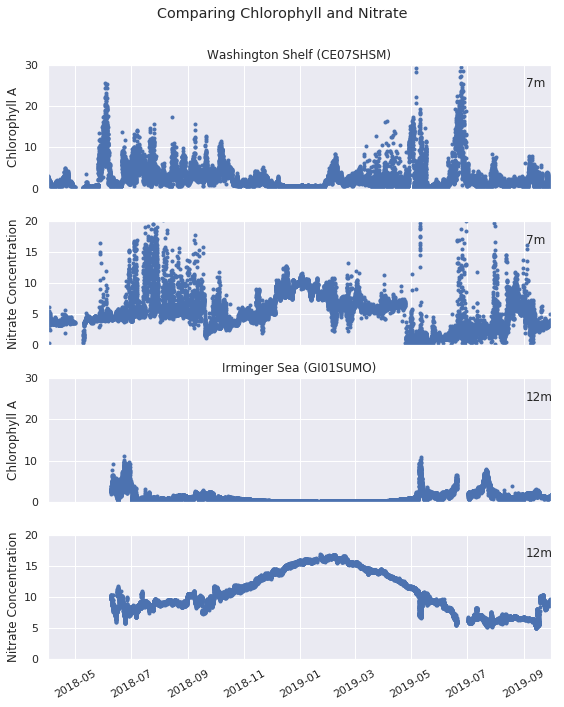

In [25]:
# Plot the data
fig,axs = plt.subplots(len(out), sharex=True, sharey=False, figsize=(8,10))

for jj in range(len(out)):
  axs[jj].scatter(out[jj]['time'], out[jj]['value'], marker='.')
  #axs[jj].set(ylabel=instruments[jj][5])
  #axs[jj].set_title('-'.join(instruments[jj][0:3]))
  axs[jj].text(.95, .9, ('%sm' % instruments[jj][-1]), horizontalalignment='left', verticalalignment='top', transform=axs[jj].transAxes)
  
plt.xlim(datetime.date(2018,4,1),datetime.date(2019,10,1))
plt.xticks(rotation=30)

axs[0].set_ylim(0,30)
axs[1].set_ylim(0,20)
axs[2].set_ylim(0,30)
axs[3].set_ylim(0,20)

axs[0].set_ylabel('Chlorophyll A')
axs[1].set_ylabel('Nitrate Concentration')
axs[2].set_ylabel('Chlorophyll A')
axs[3].set_ylabel('Nitrate Concentration')

axs[0].set_title('Washington Shelf (CE07SHSM)')
axs[2].set_title('Irminger Sea (GI01SUMO)')

fig.suptitle('Comparing Chlorophyll and Nitrate')
fig.tight_layout()
fig.subplots_adjust(top=0.9)

plt.savefig('silke_chl_nitrate2.png')

## Final Dataset

In [0]:
# Combine Datasets
d1 = pd.DataFrame(data={'time': out[0]['time'], 'Endurance Chl': out[0]['value']})
d2 = pd.DataFrame(data={'time': out[1]['time'], 'Endurance Nitrate': out[1]['value']})
d3 = pd.DataFrame(data={'time': out[2]['time'], 'Irminger Chl': out[2]['value']})
d4 = pd.DataFrame(data={'time': out[3]['time'], 'Irminger Nitrate': out[3]['value']})

df = d1.combine_first(d2).combine_first(d3).combine_first(d4)
df = df.set_index('time')

In [0]:
# Averaging
df2 = df.resample('2H').mean()

In [28]:
df2.shape

(6576, 4)

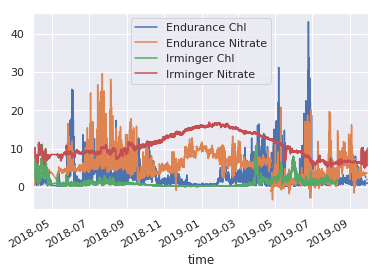

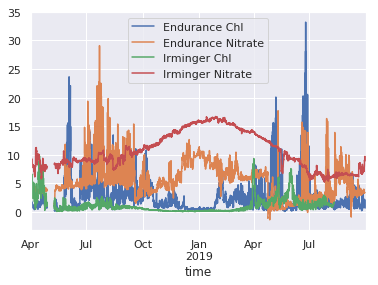

In [31]:
df.plot();
df2.plot();
plt.savefig('silke_chl_nitrate3.png')

In [0]:
df2.to_csv('chl_nitrate.csv')